In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

import kontrol
import kontrol.core.math
import kontrol.core.controlutils

# log10 N_a, log10 N_b, a, b  # copied from IP_noise.ipynb
lvdt_h1_args = [-2.59488005, -1.87371354,  0.61426591,  0.00910531]
lvdt_h2_args = [-2.28542876, -1.81372454,  0.6704747,   0.00981625]
lvdt_h3_args = [-2.53314227, -2.02659373,  0.50476805,  0.00909585]
geo_h1_args = [-4.16425554, -4.59344773,  3.3799076,   0.59570675]
geo_h2_args = [-4.35840285, -4.8259079,   3.12802332,  0.60722819]
geo_h3_args = [-4.38806483, -5.20264628,  3.28124791,  0.40256418]

# From https://gwdoc.icrr.u-tokyo.ac.jp/DocDB/0076/T1807663/003/T1807663-v3%20SR%20Matrix%20Calc.pdf
lvdt2eul = np.array([
    [0.616364, -0.528193, -0.0881709],
    [0.254047, 0.406763, -0.66081],
    [0.556242, 0.556242, 0.556242]])

# From https://klog.icrr.u-tokyo.ac.jp/osl/?r=17180
lvdtalign = np.array([[0.94872, -0.2183, 0.00417], [0.22295, 0.94869, 0.00098], [0.00866, 0.03869, 0.99999]])

lvdt_sensing = lvdtalign @ lvdt2eul

acc2eul = np.array([[0.61811, -0.5187, -0.1179], [0.23597, 0.43458, -0.6507], [0.55946, 0.55951, 0.57380]])
accalign = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

acc_sensing = accalign @ acc2eul
geo_sensing = acc_sensing

In [2]:
f, noise_seis_x = np.loadtxt("../data/X_mean_DISP.txt")[:,0], np.loadtxt("../data/X_mean_DISP.txt")[:,1]
f, noise_seis_y = np.loadtxt("../data/Y_mean_DISP.txt")[:,0], np.loadtxt("../data/Y_mean_DISP.txt")[:,1]

# flatten low frequency content to avoid seismometer noise
i_cutoff = scipy.signal.argrelmin(noise_seis_x)[0][0]
for i in range(len(noise_seis_x)):
    if i < i_cutoff:
        noise_seis_x[i] = noise_seis_x[i_cutoff]
i_cutoff = scipy.signal.argrelmin(noise_seis_y)[0][0]
for i in range(len(noise_seis_y)):
    if i < i_cutoff:
        noise_seis_y[i] = noise_seis_y[i_cutoff]

## ignore high frequency crap
mask = f<30
f = f[mask]
noise_seis_x = noise_seis_x[mask]
noise_seis_y = noise_seis_y[mask]

## Scale to um
noise_seis_x *= 1e6
noise_seis_y *= 1e6

Noise model
\begin{equation}
    N(f) = \left[\left(\frac{N_a}{f^a}\right)^2 + \left(\frac{N_b}{f^b}\right)^2\right]^{\frac{1}{2}}
\end{equation}

In [3]:
def noise_model(f, log_n_a, log_n_b, a, b):
    n_a = 10**log_n_a
    n_b = 10**log_n_b
    return ((n_a/f**a)**2 + (n_b/f**b)**2)**0.5

def cost(args, model, x_data, y_data, weight=None):
    if weight is None:
        weight = np.ones_like(y_data)
    y_model = model(x_data, *args)
    return np.sum(np.abs((np.log(y_model+1e-25) - np.log(y_data+1e-25))*weight))

In [60]:
len(f)

7679

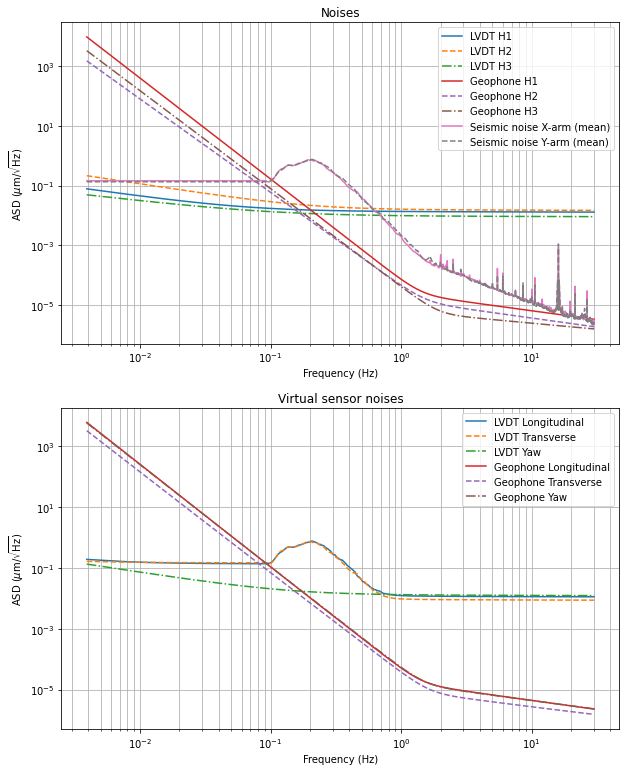

In [5]:
#f = np.linspace(1e-2, 1e1, 1000)
## Raw sensor signals
f_geo = np.linspace(1e-3, 3e1, 10000)

noise_lvdt_h1 = noise_model(f, *lvdt_h1_args)
noise_lvdt_h2 = noise_model(f, *lvdt_h2_args)
noise_lvdt_h3 = noise_model(f, *lvdt_h3_args)
noise_geo_h1 = noise_model(f, *geo_h1_args)
noise_geo_h2 = noise_model(f, *geo_h2_args)
noise_geo_h3 = noise_model(f, *geo_h3_args)

noise_lvdt = np.array([noise_lvdt_h1, noise_lvdt_h2, noise_lvdt_h3])
noise_geo = np.array([noise_geo_h1, noise_geo_h2, noise_geo_h3])

## Virtual sensor signals in longitudinal, transverse, and yaw direction.
noise_lvdt_l = kontrol.core.math.quad_sum(
    lvdt_sensing[0,0]*noise_lvdt[0], lvdt_sensing[0,1]*noise_lvdt[1], lvdt_sensing[0,2]*noise_lvdt[2])
noise_lvdt_t = kontrol.core.math.quad_sum(
    lvdt_sensing[1,0]*noise_lvdt[0], lvdt_sensing[1,1]*noise_lvdt[1], lvdt_sensing[1,2]*noise_lvdt[2])
noise_lvdt_y = kontrol.core.math.quad_sum(
    lvdt_sensing[2,0]*noise_lvdt[0], lvdt_sensing[2,1]*noise_lvdt[1], lvdt_sensing[2,2]*noise_lvdt[2])
noise_geo_l = kontrol.core.math.quad_sum(
    geo_sensing[0,0]*noise_geo[0], geo_sensing[0,1]*noise_geo[1], geo_sensing[0,2]*noise_geo[2])
noise_geo_t = kontrol.core.math.quad_sum(
    geo_sensing[1,0]*noise_geo[0], geo_sensing[1,1]*noise_geo[1], geo_sensing[1,2]*noise_geo[2])
noise_geo_y = kontrol.core.math.quad_sum(
    geo_sensing[2,0]*noise_geo[0], geo_sensing[2,1]*noise_geo[1], geo_sensing[2,2]*noise_geo[2])

## Assuming seismic noise coupling in LVDT L and T.
noise_lvdt_l_seis = kontrol.core.math.quad_sum(
    noise_lvdt_l, noise_seis_y)
noise_lvdt_t_seis = kontrol.core.math.quad_sum(
    noise_lvdt_t, noise_seis_x)


plt.figure(figsize=(10, 13))
plt.subplot(211, title="Noises")
plt.loglog(f, noise_lvdt_h1, "-", label="LVDT H1")
plt.loglog(f, noise_lvdt_h2, "--", label="LVDT H2")
plt.loglog(f, noise_lvdt_h3, "-.", label="LVDT H3")
plt.loglog(f, noise_geo_h1, "-", label="Geophone H1")
plt.loglog(f, noise_geo_h2, "--",label="Geophone H2")
plt.loglog(f, noise_geo_h3, "-.",label="Geophone H3")
plt.loglog(f, noise_seis_x, "-", label="Seismic noise X-arm (mean)")
plt.loglog(f, noise_seis_y, "--", label="Seismic noise Y-arm (mean)")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("ASD ($\mu\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
plt.xlabel("Frequency (Hz)")

plt.subplot(212, title="Virtual sensor noises")
# plt.loglog(f, noise_lvdt_l, label="LVDT Longitudinal")
# plt.loglog(f, noise_lvdt_t, label="LVDT Transverse")
plt.loglog(f, noise_lvdt_l_seis, "-", label="LVDT Longitudinal")
plt.loglog(f, noise_lvdt_t_seis, "--", label="LVDT Transverse")
plt.loglog(f, noise_lvdt_y, "-.", label="LVDT Yaw")
plt.loglog(f, noise_geo_l, "-", label="Geophone Longitudinal")
plt.loglog(f, noise_geo_t, "--", label="Geophone Transverse")
plt.loglog(f, noise_geo_y, "-.", label="Geophone Yaw")

plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("ASD ($\mu\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
plt.xlabel("Frequency (Hz)")

# plt.savefig("ip_sensor_noises_empirical.png")

In [56]:
## Fit LVDT L noise. Fix random seed so results are reproducible.

np.random.seed(123)
n1 = kontrol.FrequencySeries(f, noise_lvdt_l_seis)
_ = n1.fit_zpk(order=1, padding=True, fit="x", optimizer_kwargs={})
__ = n1.fit_tf(x0=tf_args)

In [57]:
__

   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e

In [48]:
scipy.__version__

'1.6.0'

array([1.55082480e+00, 5.47619523e+01, 8.36443781e+02, 7.23241425e+03,
       3.89434444e+04, 1.35690774e+05, 3.09829576e+05, 4.65079549e+05,
       4.61101479e+05, 3.01096951e+05, 1.26767082e+05, 3.25748053e+04,
       4.51142707e+03, 2.41758058e+02, 1.55889986e+02, 2.94825187e+03,
       2.52941318e+04, 1.30343929e+05, 4.49867754e+05, 1.09684724e+06,
       1.93963413e+06, 2.51057507e+06, 2.36600676e+06, 1.58944207e+06,
       7.28313697e+05, 2.08836574e+05, 3.10023033e+04, 1.28153432e+03])

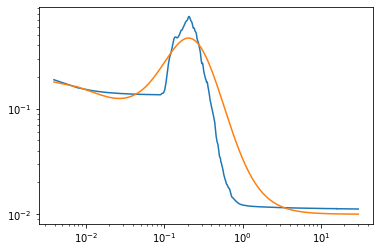

In [54]:
import kontrol.frequency_series.conversion as con

z = [0.02, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.8, 0.8, 0.8, 0.8, 0.8, 1]
p = [0.01, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.5]
gain = [noise_lvdt_l_seis[0]]
args = z + p + gain
zpk_model = con.args2zpk(f, args)

plt.loglog(f, noise_lvdt_l_seis)
plt.loglog(f, abs(zpk_model))

zpk_args = args
tf_zpk = con.args2controltf(zpk_args)
tf_zpk
tf_args = np.append(tf_zpk.num[0][0], tf_zpk.den[0][0])
tf_args
# f
# noise_lvdt_l_seis

In [93]:
_

   direc: array([[ 9.76882723e-03,  1.92490033e-03,  5.67238311e-04,
         6.21372882e-04, -2.63728422e-04,  9.76893178e-03,
         1.41324225e-03, -1.68645865e-04,  5.86035655e-04,
        -2.63351576e-04],
       [ 3.15447993e-03, -1.73715309e-03, -8.19939504e-04,
        -2.84416707e-04,  2.11837701e-04,  3.17282662e-03,
        -2.02440824e-03,  6.05975817e-04, -1.18128248e-03,
         2.26181580e-04],
       [-4.32764785e-03,  6.54042389e-02,  2.80826105e-02,
         1.67271975e-02, -1.08563070e-02,  7.51120844e-03,
         6.60663778e-02, -8.62302781e-03,  1.65015893e-02,
        -1.16092245e-02],
       [-7.41577124e-03, -5.42706661e-04, -1.46611142e-04,
        -9.94615942e-05,  1.96703404e-05, -7.40060161e-03,
        -1.53488402e-04,  1.72963845e-05, -7.69910656e-05,
         1.87828959e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
 

In [6]:
# ## Fit LVDT Y noise. Fix random seed so results are reproducible.

# np.random.seed(123)
# n1_y = kontrol.FrequencySeries(f, noise_lvdt_y)
# _ = n1_y.fit_zpk(order=4, padding=True, fit="x", optimizer_kwargs={"tol": 1e-6})
# _ = n1_y.fit_tf()

In [63]:
## Fit Geophone L noise. Fix random seed so results are reproducible.

np.random.seed(123)
n2 = kontrol.FrequencySeries(f, noise_geo_l)
_ = n2.fit_zpk(order=4, padding=True, fit="x")
_ = n2.fit_tf(optimizer_kwargs={"options": {"ftol": 1e-8, "maxfev": int(9*1e6)}})

In [8]:
# ## Fit Geophone Y noise. Fix random seed so results are reproducible.

# np.random.seed(123)
# n2_y = kontrol.FrequencySeries(f, noise_geo_y)
# _ = n2_y.fit_zpk(order=4, padding=True, fit="x")
# _ = n2_y.fit_tf()

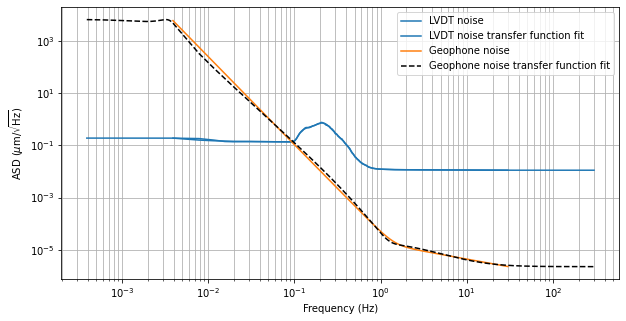

In [107]:
plt.figure(figsize=(10, 5))
plt.loglog(n1.f, n1.x, label="LVDT noise")
plt.loglog(n1.f_tf, abs(n1.x_tf), label="LVDT noise transfer function fit")
plt.loglog(n2.f, n2.x, label="Geophone noise")
plt.loglog(n2.f_tf, abs(n2.x_tf), "k--", label="Geophone noise transfer function fit")
# plt.loglog(n1.f_tf, abs(n1_stable(1j*2*np.pi*n1.f_tf)))
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("ASD ($\mu\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
plt.xlabel("Frequency (Hz)")
# plt.xlim(min(f), max(f))
# plt.savefig("ip_l_noise_fit.png")
plt.show()
## We might wanna fit the geophone noise to lower freuqencies like 1e-3 Hz...



In [10]:
# plt.figure(figsize=(10, 5))
# plt.title("Yaw")
# plt.loglog(n1_y.f, n1_y.x, label="LVDT noise")
# plt.loglog(n1_y.f_tf, abs(n1_y.x_tf), label="LVDT noise transfer function fit")
# plt.loglog(n2_y.f, n2_y.x, label="Geophone noise")
# plt.loglog(n2_y.f_tf, abs(n2_y.x_tf), label="Geophone noise transfer function fit")
# plt.legend(loc=0)
# plt.grid(which="both")
# plt.ylabel("ASD ($\mu\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
# plt.xlabel("Frequency (Hz)")
# plt.xlim(min(f), max(f))
# # plt.savefig("ip_l_noise_fit.png")
# plt.show()

In [69]:
## stablize the transfer functions before proceeding 
n1_stable = kontrol.core.controlutils.convert_unstable_tf(n1.tf)
n2_stable = kontrol.core.controlutils.convert_unstable_tf(n2.tf)

In [12]:
# ## stablize the transfer functions before proceeding 
# n1_y_stable = kontrol.core.controlutils.convert_unstable_tf(n1_y.tf)
# n2_y_stable = kontrol.core.controlutils.convert_unstable_tf(n2_y.tf)

In [68]:
n2.tf.pole()

array([-2.17778429+0.j        ,  0.00491008+0.02201423j,
        0.00491008-0.02201423j, -0.00963134+0.j        ])

In [41]:
n2.tf

TransferFunction(array([1.01365692e+12, 9.52951890e+13, 9.36431912e+13, 2.05742029e+15,
       2.57552145e+16]), array([4.40672368e+17, 4.75905803e+17, 0.00000000e+00, 1.28748414e+13,
       3.96907520e+10]))

In [100]:
n1_stable

TransferFunction(array([5.64945383e-02, 2.26855624e+00, 2.56802050e+01, 1.97772969e+02,
       9.77033356e+02, 3.71873404e+03, 8.89139689e+03, 1.75330984e+04,
       1.37495433e+04, 1.05712002e+04, 4.05032684e+03, 1.32437316e+03,
       1.05800363e+02, 7.88100333e+00]), array([5.06461455e+00, 1.63724480e+02, 1.06670396e+03, 6.53031853e+03,
       1.91155009e+04, 5.32285711e+04, 7.89936670e+04, 1.12389355e+05,
       9.07209369e+04, 6.51601568e+04, 2.70998120e+04, 8.68820553e+03,
       6.81933177e+02, 4.17337255e+01]))

In [101]:
n1_stable.minreal()

TransferFunction(array([1.11547558e-02, 4.47922782e-01, 5.07051519e+00, 3.90499548e+01,
       1.92913665e+02, 7.34258058e+02, 1.75559202e+03, 3.46188208e+03,
       2.71482523e+03, 2.08726649e+03, 7.99730522e+02, 2.61495351e+02,
       2.08901116e+01, 1.55609144e+00]), array([1.00000000e+00, 3.23271354e+01, 2.10618981e+02, 1.28940090e+03,
       3.77432492e+03, 1.05098958e+04, 1.55971726e+04, 2.21910975e+04,
       1.79127031e+04, 1.28657682e+04, 5.35081432e+03, 1.71547221e+03,
       1.34646609e+02, 8.24025701e+00]))

In [103]:
n2_stable.minreal()

TransferFunction(array([2.27887210e-06, 2.44556813e-04, 2.50604310e-03, 2.06828084e-02,
       7.01804420e-02]), array([1.00000000e+00, 2.19723579e+00, 4.29644798e-02, 1.31879257e-03,
       1.06707101e-05]))

In [60]:
n1_stable.zero()

array([ -7.28276039+1915.16672062j,  -7.28276039-1915.16672062j,
       -10.58247921   +0.j        ,  -1.99152083   +4.50317097j,
        -1.99152083   -4.50317097j])

In [104]:
## Make complementary filters using H-infinity synthesis

comp = kontrol.ComplementaryFilter(noise1=n1_stable, noise2=n2_stable, f=f, unit="Hz")
comp.hinfsynthesis()

# Just for interest, make complementary filters using H2 synthesis as well.
# comp_h2 = kontrol.ComplementaryFilter(noise1=n1_stable, noise2=n2_stable, f=f, unit="Hz")
# comp_h2.h2synthesis()

In [14]:
# ## Make complementary filters using H-infinity synthesis
# comp_y = kontrol.ComplementaryFilter(noise1=n1_y_stable, noise2=n2_y_stable, f=f, unit="Hz")
# comp_y.hinfsynthesis()

# # ## Just for interest, make complementary filters using H2 synthesis as well.
# # comp_h2 = kontrol.ComplementaryFilter(noise1=n1_stable, noise2=n2_stable, f=f, unit="Hz")
# # comp_h2.h2synthesis()

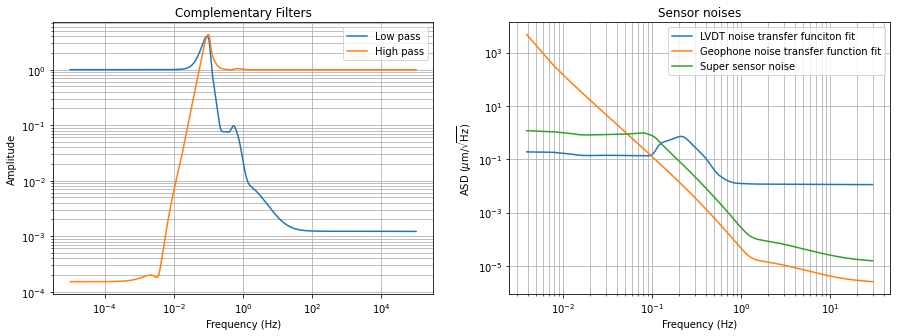

In [105]:
f_eval = np.logspace(-5, 5, 1000000)
# f_eval=f
plt.figure(figsize=(15, 5))
plt.subplot(121, title="Complementary Filters")
plt.loglog(f_eval, abs(comp.filter1(2*np.pi*1j*f_eval)), label="Low pass")
plt.loglog(f_eval, abs(comp.filter2(2*np.pi*1j*f_eval)), label="High pass")
# plt.loglog(comp_h2.f, abs(comp_h2.filter1(2*np.pi*1j*f)), label="Low pass H2")
# plt.loglog(comp_h2.f, abs(comp_h2.filter2(2*np.pi*1j*f)), label="High pass H2")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")

plt.subplot(122, title="Sensor noises")
plt.loglog(comp.f, comp.noise1, label="LVDT noise transfer funciton fit")
plt.loglog(comp.f, comp.noise2, label="Geophone noise transfer function fit")
plt.loglog(comp.f, comp.noise_super, label="Super sensor noise")
# plt.loglog(comp.f, comp_h2.noise_super, "--", label="Super sensor noise (predicted) H2")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("ASD ($\mu\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
plt.xlabel("Frequency (Hz)")

# plt.savefig("ip_l_complementary_filter_sensor_noises.png")
plt.show()



In [75]:
np.log10(comp.noise_super) - np.log10(comp.noise1)

array([ 0.79358703,  0.7690418 ,  0.77019282, ..., -2.85607444,
       -2.85608603, -2.85609761])

In [64]:
comp.f

array([1.00000000e-03, 4.00020002e-03, 7.00040004e-03, ...,
       2.99939996e+01, 2.99969998e+01, 3.00000000e+01])

In [49]:
unitary = blend_lvdtl + comp.filter2
unitary.minreal()

TransferFunction(array([1.00000000e+00, 2.14165267e+03, 2.14228412e+06, 1.29607371e+09,
       5.18413607e+11, 1.40983889e+14, 2.58029805e+16, 3.01471841e+18,
       1.98671634e+20, 5.58770371e+21, 9.76741763e+22, 1.20213229e+24,
       1.11274388e+25, 8.01312134e+25, 4.57430040e+26, 2.08698705e+27,
       7.61987729e+27, 2.21793550e+28, 5.11221256e+28, 9.27977776e+28,
       1.32607527e+29, 1.50059856e+29, 1.35747418e+29, 9.89647382e+28,
       5.83413542e+28, 2.77154656e+28, 1.04779478e+28, 3.07170023e+27,
       6.64181202e+26, 9.55334541e+25, 6.96249359e+24]), array([1.00000000e+00, 2.14165267e+03, 2.14228412e+06, 1.29607371e+09,
       5.18413607e+11, 1.40983889e+14, 2.58029805e+16, 3.01471841e+18,
       1.98671634e+20, 5.58770371e+21, 9.76741763e+22, 1.20213229e+24,
       1.11274388e+25, 8.01312134e+25, 4.57430040e+26, 2.08698705e+27,
       7.61987729e+27, 2.21793550e+28, 5.11221256e+28, 9.27977776e+28,
       1.32607527e+29, 1.50059856e+29, 1.35747418e+29, 9.89647382e+28,
   

In [70]:
comp.filter1

TransferFunction(array([1.79128744e-15, 1.22770065e+06, 1.82605318e+08, 9.01743075e+12,
       1.24263845e+15, 1.65743295e+19, 2.10121047e+21, 6.09385386e+22,
       9.05561439e+23, 8.81429307e+24, 6.02963762e+25, 2.92600502e+26,
       1.01463367e+27, 2.41778355e+27, 3.68428967e+27, 4.40161379e+27,
       3.21899805e+27, 9.43643893e+26, 1.31477613e+26]), array([1.00000000e+00, 1.05906309e+09, 6.61852290e+10, 7.77086773e+15,
       3.72348943e+17, 1.42556951e+22, 4.75352405e+23, 6.77982318e+24,
       5.89806916e+25, 3.58367306e+26, 1.51526975e+27, 4.62672617e+27,
       9.37696975e+27, 1.24820331e+28, 1.13292182e+28, 7.24121840e+27,
       3.23350513e+27, 9.43846901e+26, 1.31525202e+26]))

In [58]:
comp.filter1.pole()

array([-2.09020237e+08  +0.j        , -2.63067729e+02+177.28611718j,
       -2.63067729e+02-177.28611718j, -2.63067070e+02+177.2859882j ,
       -2.63067070e+02-177.2859882j , -3.11063786e+00  +4.76121969j,
       -3.11063786e+00  -4.76121969j, -3.11043315e+00  +4.75912279j,
       -3.11043315e+00  -4.75912279j, -1.52229884e-01  +0.51121709j,
       -1.52229884e-01  -0.51121709j, -4.37633629e-01  +0.35284639j,
       -4.37633629e-01  -0.35284639j, -5.86242476e-01  +0.j        ,
       -2.17232559e+00  +0.j        , -2.17630351e+00  +0.j        ])

In [52]:
comp.filter1.den

[[array([1.00000000e+00, 2.09021308e+08, 2.23824873e+11, 1.04051964e+14,
         2.40313688e+16, 2.54716073e+18, 4.36859142e+19, 4.37040441e+20,
         2.70685092e+21, 1.12293950e+22, 2.97293605e+22, 4.76367335e+22,
         4.65837999e+22, 3.02321096e+22, 1.33268429e+22, 3.78382826e+21,
         5.51532032e+20])]]

In [44]:
comp.filter2.minreal().zero()

array([-2.08810143e+08+0.00000000e+00j, -2.63057213e+02+1.77298782e+02j,
       -2.63057213e+02-1.77298782e+02j, -3.14431503e+00+4.81420601e+00j,
       -3.14431503e+00-4.81420601e+00j, -3.11053759e+00+4.76017118e+00j,
       -3.11053759e+00-4.76017118e+00j, -2.60111344e+00+0.00000000e+00j,
       -2.17442263e+00+0.00000000e+00j, -5.77767053e-01+9.62379702e-01j,
       -5.77767053e-01-9.62379702e-01j, -5.05554493e-03+2.19880872e-02j,
       -5.05554493e-03-2.19880872e-02j, -9.35460926e-03+0.00000000e+00j])

In [32]:
blend_lvdtl_num = comp.filter1.num[0][0][1:]
blend_lvdtl_den = comp.filter2.den[0][0]


In [33]:
blend_lvdtl = control.tf(blend_lvdtl_num, blend_lvdtl_den)

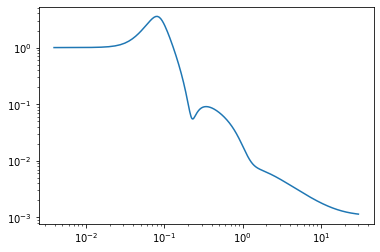

In [34]:
plt.loglog(f, abs(blend_lvdtl(1j*2*np.pi*f)))

In [16]:
# # Yaw
# plt.figure(figsize=(15, 5))
# plt.subplot(121, title="Complementary Filters")
# plt.loglog(comp_y.f, abs(comp_y.filter1(2*np.pi*1j*f)), label="Low pass")
# plt.loglog(comp_y.f, abs(comp_y.filter2(2*np.pi*1j*f)), label="High pass")
# # plt.loglog(comp_h2.f, abs(comp_h2.filter1(2*np.pi*1j*f)), label="Low pass H2")
# # plt.loglog(comp_h2.f, abs(comp_h2.filter2(2*np.pi*1j*f)), label="High pass H2")
# plt.legend(loc=0)
# plt.grid(which="both")
# plt.ylabel("Amplitude")
# plt.xlabel("Frequency (Hz)")

# plt.subplot(122, title="Sensor noises")
# plt.loglog(comp_y.f, comp_y.noise1, label="LVDT noise transfer funciton fit")
# plt.loglog(comp_y.f, comp_y.noise2, label="Geophone noise transfer function fit")
# plt.loglog(comp_y.f, comp_y.noise_super, label="Super sensor noise")
# # plt.loglog(comp.f, comp_h2.noise_super, "--", label="Super sensor noise (predicted) H2")
# plt.legend(loc=0)
# plt.grid(which="both")
# plt.ylabel("ASD ($\mu\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
# plt.xlabel("Frequency (Hz)")

# # plt.savefig("ip_l_complementary_filter_sensor_noises.png")
# plt.show()


In [17]:
# with open("ip_blend_lvdtl.txt", "w") as f:
#     f.write(blend_lvdtl.foton)
# with open("ip_blend_geol.txt", "w") as f:
#     f.write(blend_geol.foton)

In [72]:
## Benchmark
import kontrol.complementary_filter.predefined
import control

sekiguchi_filter1, sekiguchi_filter2 = kontrol.complementary_filter.predefined.sekiguchi([0.08*2*np.pi])
noise_super_sekiguchi = kontrol.core.math.quad_sum(
    abs(sekiguchi_filter1(1j*2*np.pi*f))*noise_lvdt_l_seis,
    abs(sekiguchi_filter2(1j*2*np.pi*f))*noise_geo_l
)

s = control.tf("s")
current_filter1 = 1.25 * (s**2 + 0.25*s + 0.025) / (s**5 + 2.5*s**4 + 2.5*s**3 + 1.25*s**2 + 0.3125*s + 0.03125)
current_filter2 = 1-current_filter1
noise_super_current = kontrol.core.math.quad_sum(
    abs(current_filter1(1j*2*np.pi*f))*noise_lvdt_l_seis,
    abs(current_filter2(1j*2*np.pi*f))*noise_geo_l,
)

noise_super_hinfinity = kontrol.core.math.quad_sum(
    abs(comp.filter1(1j*2*np.pi*f))*noise_lvdt_l_seis,
    abs(comp.filter2(1j*2*np.pi*f))*noise_geo_l,
)

noise_super_h2 = kontrol.core.math.quad_sum(
    abs(comp_h2.filter1(1j*2*np.pi*f))*noise_lvdt_l_seis,
    abs(comp_h2.filter2(1j*2*np.pi*f))*noise_geo_l,
)

df = f[1] - f[0]

expected_rms_current = [np.sqrt(np.sum(noise_super_current[i:]**2*df)) for i in range(len(f))]
# print(expected_rms_current)
expected_rms_sekiguchi = [np.sqrt(np.sum(noise_super_sekiguchi[i:]**2*df)) for i in range(len(f))]
# print(expected_rms_sekiguchi)
expected_rms_hinfinity = [np.sqrt(np.sum(noise_super_hinfinity[i:]**2*df)) for i in range(len(f))]
# print(expected_rms_hinfinity)
# expected_rms_h2 = [np.sqrt(sum(noise_super_h2[i:]**2*df)) for i in range(len(f))]

ValueError: operands could not be broadcast together with shapes (7679,) (10000,) 

In [ ]:
# # Yaw
# sekiguchi_filter1, sekiguchi_filter2 = kontrol.complementary_filter.predefined.sekiguchi([0.159*2*np.pi])
# noise_super_sekiguchi = kontrol.core.math.quad_sum(
#     abs(sekiguchi_filter1(1j*2*np.pi*f))*noise_lvdt_l_seis,
#     abs(sekiguchi_filter2(1j*2*np.pi*f))*noise_geo_l
# )

# s = control.tf("s")
# current_filter1 = 10 * (s**2 + 0.5*s + 0.1) / (s**5 + 5*s**4 + 10*s**3 + 10*s**2 + 5*s + 1)
# current_filter2 = 1-current_filter1
# noise_super_current = kontrol.core.math.quad_sum(
#     abs(current_filter1(1j*2*np.pi*f))*noise_lvdt_y,
#     abs(current_filter2(1j*2*np.pi*f))*noise_geo_y,
# )

# noise_super_hinfinity = kontrol.core.math.quad_sum(
#     abs(comp_y.filter1(1j*2*np.pi*f))*noise_lvdt_y,
#     abs(comp_y.filter2(1j*2*np.pi*f))*noise_geo_y,
# )

# noise_super_h2 = kontrol.core.math.quad_sum(
#     abs(comp_h2.filter1(1j*2*np.pi*f))*noise_lvdt_y,
#     abs(comp_h2.filter2(1j*2*np.pi*f))*noise_geo_y,
# )

# df = f[1] - f[0]

# expected_rms_current = [np.sqrt(np.sum(noise_super_current[i:]**2*df)) for i in range(len(f))]
# print(expected_rms_current[0])
# expected_rms_sekiguchi = [np.sqrt(np.sum(noise_super_sekiguchi[i:]**2*df)) for i in range(len(f))]
# print(expected_rms_sekiguchi[0])
# expected_rms_hinfinity = [np.sqrt(np.sum(noise_super_hinfinity[i:]**2*df)) for i in range(len(f))]
# print(expected_rms_hinfinity[0])

In [ ]:
# with open("sekiguchi_lvdtl_80mHz.txt", "w") as f:
#     f.write(kontrol.TransferFunction(sekiguchi_filter1).foton)
with open("sekiguchi_geol_80mHz.txt", "w") as f:
    f.write(kontrol.TransferFunction(sekiguchi_filter2).foton)

In [ ]:
noise_lower_bound = [min(noise_lvdt_l_seis[i], noise_geo_l[i]) for i in range(len(f))]

In [ ]:
plt.rcParams["font.size"] = 14
plt.figure(figsize=(10, 15))
plt.subplot(211, title="Complementary Filters")
plt.loglog(f, abs(current_filter1(1j*2*np.pi*f)), label="Joris 80 mHz")
plt.loglog(f, abs(current_filter2(1j*2*np.pi*f)), label="Joris 80 mHz")
plt.loglog(f, abs(sekiguchi_filter1(1j*2*np.pi*f)), "--", label="Sekiguchi 80 mHz")
plt.loglog(f, abs(sekiguchi_filter2(1j*2*np.pi*f)), "--", label="Sekiguchi 80 mHz")
plt.loglog(f, abs(comp.filter1(2*np.pi*1j*f)), "-.", label="$\mathcal{H}_\infty$ method")
plt.loglog(f, abs(comp.filter2(2*np.pi*1j*f)), "-.", label="$\mathcal{H}_\infty$ method")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")

# '#1f77b4', '#ff7f0e', '#2ca02c'
plt.subplot(212, title="Super sensor noise (Estimated using empirical noise models and mean seismic noise)")
plt.loglog(f, noise_super_current, label="Joris 80 mHz")
plt.loglog(f, expected_rms_current, "--", color="#1f77b4", markersize=2, label="Expected RMS (0.7979 $\mu \mathrm{m}$)")
plt.loglog(f, noise_super_sekiguchi, label="Sekiguchi 80 mHz")
plt.loglog(f, expected_rms_sekiguchi, "--", color="#ff7f0e", markersize=2, label="Expected RMS (0.5916 $\mu \mathrm{m}$)")
plt.loglog(f, noise_super_hinfinity, label="$\mathcal{H}_\infty$ method")
plt.loglog(f, expected_rms_hinfinity, "--", color="#2ca02c", markersize=2, label="Expected RMS (0.3631 $\mu \mathrm{m}$)")
# plt.loglog(f, expected_rms_h2, "y.")
# plt.loglog(f, noise_lower_bound, label="Lower bound")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("ASD ($\mu\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
plt.xlabel("Frequency (Hz)")

plt.savefig("ip_complementary_filters_comparison.png")
plt.show()

In [ ]:
# # Yaw
# plt.rcParams["font.size"] = 14
# plt.figure(figsize=(10, 15))
# plt.subplot(211, title="Complementary Filters")
# plt.loglog(f, abs(current_filter1(1j*2*np.pi*f)), label="Joris 159 mHz")
# plt.loglog(f, abs(current_filter2(1j*2*np.pi*f)), label="Joris 159 mHz")
# plt.loglog(f, abs(sekiguchi_filter1(1j*2*np.pi*f)), "--", label="Sekiguchi 159 mHz")
# plt.loglog(f, abs(sekiguchi_filter2(1j*2*np.pi*f)), "--", label="Sekiguchi 159 mHz")
# plt.loglog(f, abs(comp_y.filter1(2*np.pi*1j*f)), "-.", label="$\mathcal{H}_\infty$ method")
# plt.loglog(f, abs(comp_y.filter2(2*np.pi*1j*f)), "-.", label="$\mathcal{H}_\infty$ method")
# plt.legend(loc=0)
# plt.grid(which="both")
# plt.ylabel("Amplitude")
# plt.xlabel("Frequency (Hz)")

# # '#1f77b4', '#ff7f0e', '#2ca02c'
# plt.subplot(212, title="Super sensor noise (Estimated using empirical noise models and mean seismic noise)")
# plt.loglog(f, noise_super_current, label="Joris 159 mHz")
# plt.loglog(f, expected_rms_current, "--", color="#1f77b4", markersize=2, label="Expected RMS (0.1153 $\mu \mathrm{m}$)")
# plt.loglog(f, noise_super_sekiguchi, label="Sekiguchi 159 mHz")
# plt.loglog(f, expected_rms_sekiguchi, "--", color="#ff7f0e", markersize=2, label="Expected RMS (0.5854 $\mu \mathrm{m}$)")
# plt.loglog(f, noise_super_hinfinity, label="$\mathcal{H}_\infty$ method")
# plt.loglog(f, expected_rms_hinfinity, "--", color="#2ca02c", markersize=2, label="Expected RMS (0.1213 $\mu \mathrm{m}$)")
# # plt.loglog(f, expected_rms_h2, "y.")
# # plt.loglog(f, noise_lower_bound, label="Lower bound")
# plt.legend(loc=0)
# plt.grid(which="both")
# plt.ylabel("ASD ($\mu\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
# plt.xlabel("Frequency (Hz)")

# # plt.savefig("ip_complementary_filters_comparison.png")
# plt.show()